# Model Free Control

tasks adapted from https://github.com/yandexdataschool/Practical_RL/  week3 and week5

## Install dependencies

In [3]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

## Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    
    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        
        if len(possible_actions) == 0:
            return 0.0

        possible_values = [self.get_qvalue(state, action) for action in possible_actions]
        value = np.max(possible_values)
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        
        gamma = self.discount
        lr = self.alpha
        
        reference_qvalue = reward + gamma * self.get_value(next_state)
        updated_qvalue = (1 - lr) * self.get_qvalue(state, action) + lr * reference_qvalue

        self.set_qvalue(state, action, updated_qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        
        if len(possible_actions) == 0:
            return None

        possible_values = [self.get_qvalue(state, action) for action in possible_actions]
        best_action = possible_actions[np.argmax(possible_values)]

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        
        possible_actions = self.get_legal_actions(state)
        action = None

        
        if len(possible_actions) == 0:
            return None

        
        epsilon = self.epsilon
        choice = random.random() > epsilon
        
        if choice:
            chosen_action = self.get_best_action(state)
        else:
            chosen_action = random.choice(possible_actions)

        return chosen_action

## Taxi-v2

Here we use the qlearning agent on taxi env from openai gym. You will need to insert a few agent functions here.

In [7]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

In [8]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

In [9]:
def play_and_train(env, agent, t_max=10**4):
    
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

eps = 2.9191091959171894e-05 mean reward = 10.0


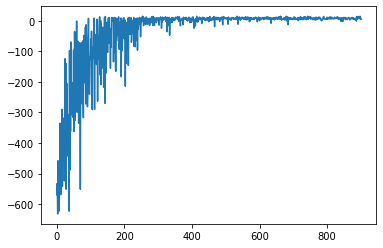

In [10]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

## Tabular Q-learning in continuous state space (Binarized state spaces)

Use agent to train efficiently on CartPole-v0. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use round(x,n_digits) (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to tuples of any kind of values.

first state:[-0.03023515  0.0473178  -0.04745015 -0.01580232]


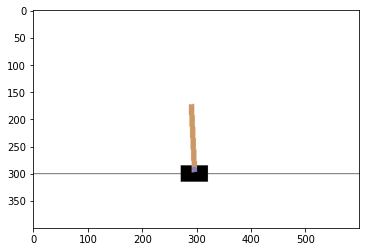

In [11]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games
We need to estimate observation distributions. To do so, we'll play a few games and record all states.

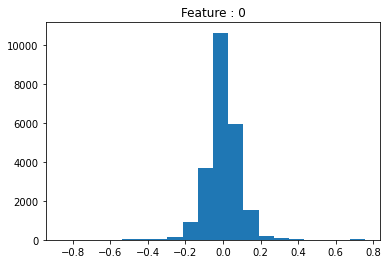

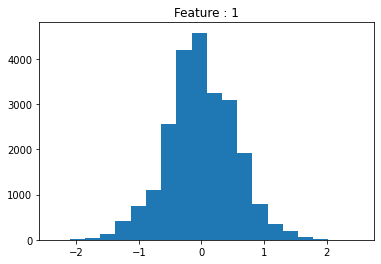

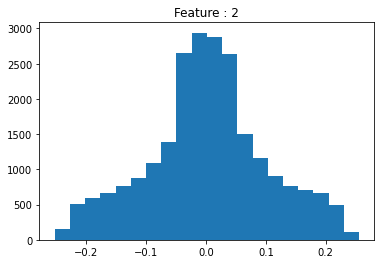

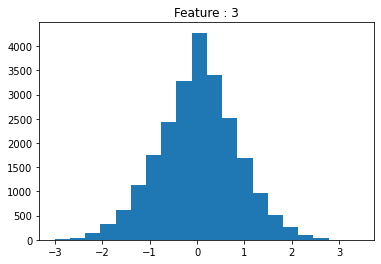

In [12]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.title('Feature : %d' % obs_i)
    plt.show()

### Binarize environment



In [13]:

from gym.core import ObservationWrapper


class Binarizer(ObservationWrapper):

    def observation(self, state):

        
        
        cart_position, cart_velocity, pole_angle, pole_velocity = state
        
        cart_position = round(cart_position, 1)
        cart_velocity = round(cart_velocity, 0)
        pole_angle = round(pole_angle, 2)
        pole_velocity = round(pole_velocity, 0)
        
        state = (cart_position, cart_velocity, pole_angle, pole_velocity,)

        return tuple(state)

In [14]:
env = Binarizer(gym.make("CartPole-v0"))

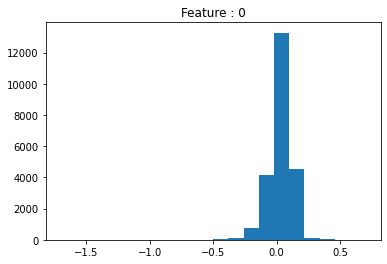

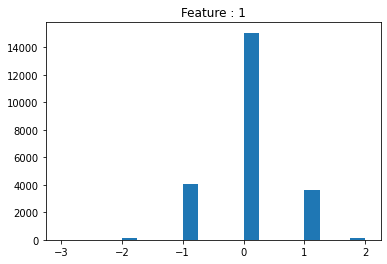

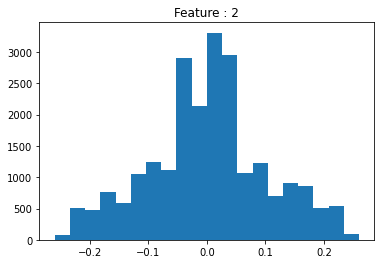

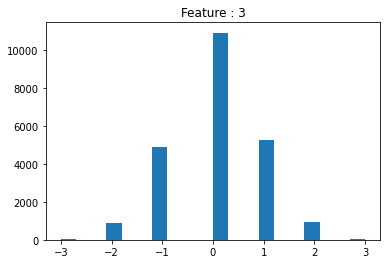

In [15]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):

    plt.hist(all_states[:, obs_i], bins=20)
    plt.title('Feature : %d' % obs_i)
    plt.show()

### Learn binarized policy 
Now let's train a policy that uses binarized state space.

Tips:

* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization.
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (len(QLearningAgent._qvalues)), but not required.
* A reasonable agent should get to an average reward of >=50.

In [16]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

In [17]:
len(agent._qvalues)

0

eps = 0.15125151678438412 mean reward = 72.6


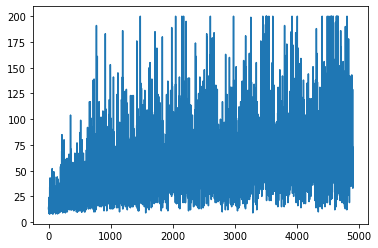

In [18]:
rewards = []
for i in range(5000):
    rewards.append(play_and_train(env, agent))

    
    if i % 100 == 0:
        agent.epsilon *= 0.99
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

## Play with your agent

In [19]:
def agent_rollout(env, agent, t_max=10**4):

    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [20]:
import gym.wrappers
env = gym.wrappers.Monitor(Binarizer(gym.make("CartPole-v0")),
                           directory="./videos", force=True)
sessions = [agent_rollout(env, agent, t_max=1000) for _ in range(100)]
env.close()

In [21]:
import glob
mp4list = glob.glob('videos/*.mp4')
mp4list

['videos/openaigym.video.0.126.video000000.mp4',
 'videos/openaigym.video.0.126.video000008.mp4',
 'videos/openaigym.video.0.126.video000064.mp4',
 'videos/openaigym.video.0.126.video000001.mp4',
 'videos/openaigym.video.0.126.video000027.mp4']

In [22]:
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML

def show_video(name):  
  if len(mp4list) > 0:
    mp4 = name
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [23]:
show_video(mp4list[3])

# 

# On-policy learning and SARSA

The policy we're gonna use is epsilon-greedy policy, where agent takes optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent can occasionally sample optimal action during random sampling by pure chance.

In [24]:
class EVSarsaAgent(QLearningAgent):
    

    def get_value(self, state):
        
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        
        if len(possible_actions) == 0:
            return 0.0

        best_action = self.get_best_action(state)
        
        state_value = 0
        for action in possible_actions:
            if action == best_action:
                state_value += (1 - epsilon) * self.get_qvalue(state, action)

            state_value += (epsilon / len(possible_actions)) * self.get_qvalue(state, action)

        return state_value

## Cliff World
Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>

# TODO: describe the problem of cliff world

In [25]:
import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [26]:

env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [27]:
def play_and_train(env, agent, t_max=10**4):
    
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [28]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

EVSARSA mean reward = -27.69
QLEARNING mean reward = -55.79


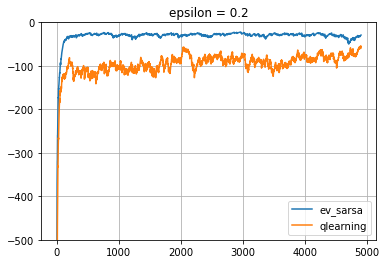

In [29]:
from IPython.display import clear_output
from pandas import DataFrame


def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
   
    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()


Let's now see what did the algorithms learn by visualizing their actions at every state.

In [30]:

def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [31]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 ^  >  >  >  >  >  v  >  v  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


# Experience replay

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on <s,a,r,s'> tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

**Training with experience replay**
1. Play game, sample <s,a,r,s'>.
2. Update q-values based on <s,a,r,s'>.
3. Store <s,a,r,s'> transition in a buffer.
    1. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.

To enable such training, first we must implement a memory structure that would act like such

In [32]:
import random


class ReplayBuffer(object):
    def __init__(self, size):
        
        self._storage = []
        self._maxsize = size

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        
        data = (obs_t, action, reward, obs_tp1, done)

        
        if len(self._storage) >= self._maxsize:
            self._storage.pop(0)
        self._storage.append(data)
            

    def sample(self, batch_size):
       
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]

        
        states = []
        actions = []
        rewards = []
        next_states = []
        is_done = []
        for idx in idxes:
            s, a, r, next_s, done = self._storage[idx]
            
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(next_s)
            is_done.append(done)
            
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(is_done)

Some tests to make sure your buffer works right

In [35]:
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(
    1) == obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(
    replay._storage) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj1
print("Success!")

Success!



Now let's use this buffer to improve training:

In [36]:
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

In [37]:
def play_and_train_with_replay(env, agent, replay=None,
                               t_max=10**4, replay_batch_size=32):
    
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
       
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        
        agent.update(s, a, r, next_s)

        if replay is not None:
            
            replay.add(s, a, r, next_s, done)

            
            s_, a_, r_, next_s_, done_ = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                agent.update(s_[i], a_[i], r_[i], next_s_[i])

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [38]:

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                                get_legal_actions=lambda s: range(n_actions))

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

replay = ReplayBuffer(1000)

Baseline : eps = 2.9191091959171894e-05 mean reward = 7.3
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 7.0


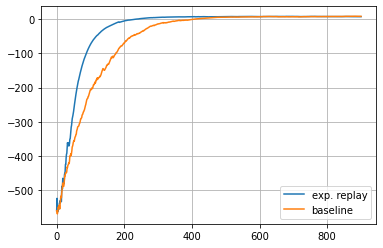

In [39]:
from IPython.display import clear_output

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(
        play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(
        env, agent_baseline, replay=None))

    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon,
              'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon,
              'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()